# EPA Embeddedness 2018-2019 Model Building

In [2]:
#Read in libs
import pandas as pd
import numpy as np
import pylab
import math
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import keras_tuner as kt
import keras
from scipy.optimize import curve_fit
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, PowerTransformer, QuantileTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score, GridSearchCV, RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import openpyxl
from scikeras.wrappers import KerasClassifier, KerasRegressor
from keras.models import Sequential 
from keras.layers import Dense, BatchNormalization, Dropout, Input
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam   
from keras import regularizers  
from keras_tuner import RandomSearch
from xgboost import XGBRegressor

## Step 1. Import Dataset

In [3]:
# Read in cleaned and transformation 2018-2019 dataset
epa_1819 = pd.read_excel('epa_1819_mdl.xlsx').drop(columns = ['Unnamed: 0'])
# Read in coordinates of EPA sites for joining
epa_coords = pd.read_csv('NRSA_1819_SiteInfo.csv').rename(columns = {'SITE_ID':'Site ID'})
epa_coords = epa_coords[['Site ID', 'LAT_DD83', 'LON_DD83']]
# Display dataframe
epa_1819

,Site ID,Mean streambed embeddedness (%),% Slow Water Habitat (YJ),Bankfull Shear Velocity (m/s) (QT),Mean Composite Topographic (CTI) [Wetness Index] (QT),Mean Water Surface Slope (%) (QT),% of watershed area classified as evergreen forest land cover (CBRT),Mean of all nitrogen content in surface or near-surface within watershed (QT),% Crop Land (CBRT),Estimated Watershed Annual Runoff (QT),Mean of all hydraulic conductivity of surface or near geology within watershed (QT),% of watershed classified as lithology type:\nalluvium and fine-textured coastal zone sediment,Mean Watershed Elevation (QT),Constraining Features_BEDROCK,Constraining Features_HILLSLOPE,Constraining Features_HUMAN,Constraining Features_NOCONST,Constraining Features_TERRACE
0,NRS18_OK_10062,100.000000,0.970282,-0.030620,0.026516,0.579510,0.000000,1.253067,1.290327,-1.475239,0.465743,0.000000,0.294669,0,0,0,0,1
1,NRS18_OK_10431,58.272727,0.249229,-0.486106,0.599384,-0.037646,0.505407,-0.215253,1.394378,0.105589,-0.298550,0.000000,-0.647199,0,0,0,0,1
2,NRS18_OK_10025,96.363636,0.970282,0.680046,0.610414,0.036675,0.739352,0.126590,0.575365,-0.128036,0.192926,23.863907,-0.747971,0,1,0,0,0
3,NRS18_WI_10091,53.418182,-0.305532,0.473759,0.003909,0.543789,0.000000,-0.094232,4.348461,-0.100471,-1.114032,0.000000,-0.631532,0,0,1,0,0
4,NRS18_WI_10006,83.222222,0.812732,-1.070554,0.813122,-1.159244,1.325693,-0.840944,0.694048,-0.023856,0.029046,0.000000,-0.254478,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1205,NRS18_ND_10676,54.909091,0.970282,-0.873889,0.339907,-1.074335,1.264714,1.036375,1.961687,-1.247105,0.800495,6.376336,0.497808,0,0,0,0,1
1206,NRS18_PA_10009,38.781818,-0.408598,-0.255881,-0.331815,-0.492270,1.108554,-0.077004,0.814169,0.315302,-0.514337,2.467807,0.108963,0,0,1,0,0
1207,NRS18_SD_10005,61.083333,-0.691478,0.208596,-0.304420,0.330490,0.213150,-0.300018,2.690357,-1.309826,0.552388,68.017044,0.141115,0,0,0,0,1
1208,NRS18_NC_10897,100.000000,0.970282,-0.692365,-0.252646,-0.853935,1.332303,-1.111449,0.957199,0.588378,-0.441851,0.000000,-0.642370,0,0,0,0,1


In [4]:
# Add coordinates for indexing purposes later
epa_1819 = epa_1819.merge(epa_coords,
                          on = 'Site ID',
                          how = 'left')
# Display df
epa_1819.describe()

,Mean streambed embeddedness (%),% Slow Water Habitat (YJ),Bankfull Shear Velocity (m/s) (QT),Mean Composite Topographic (CTI) [Wetness Index] (QT),Mean Water Surface Slope (%) (QT),% of watershed area classified as evergreen forest land cover (CBRT),Mean of all nitrogen content in surface or near-surface within watershed (QT),% Crop Land (CBRT),Estimated Watershed Annual Runoff (QT),Mean of all hydraulic conductivity of surface or near geology within watershed (QT),% of watershed classified as lithology type:\nalluvium and fine-textured coastal zone sediment,Mean Watershed Elevation (QT),Constraining Features_BEDROCK,Constraining Features_HILLSLOPE,Constraining Features_HUMAN,Constraining Features_NOCONST,Constraining Features_TERRACE,LAT_DD83,LON_DD83
count,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000,1401.000000
mean,67.291902,0.015333,-0.022699,-0.002471,-0.028191,1.696515,-0.002817,1.377621,0.040738,-0.004784,8.892418,-0.035808,0.037116,0.197002,0.072805,0.107066,0.586010,40.378132,-94.604681
std,25.365579,0.993477,1.022902,1.009464,1.014805,1.443864,1.017477,1.543692,1.008108,1.002997,22.810397,1.044379,0.189114,0.397876,0.259909,0.309308,0.492723,4.561683,14.347316
min,5.400000,-2.067508,-5.199338,-5.199338,-5.199338,0.000000,-5.199338,0.000000,-5.199338,-5.199338,0.000000,-5.199338,0.000000,0.000000,0.000000,0.000000,0.000000,27.525404,-124.298059
25%,48.000000,-0.677177,-0.696032,-0.675724,-0.692715,0.394549,-0.686350,0.000000,-0.636393,-0.680248,0.000000,-0.715218,0.000000,0.000000,0.000000,0.000000,0.000000,37.076941,-105.578540
50%,69.636364,0.371667,-0.032454,-0.006690,-0.037646,1.299638,0.004710,0.731273,0.046470,0.008466,0.000000,-0.040012,0.000000,0.000000,0.000000,0.000000,1.000000,40.864463,-94.448356
75%,90.090909,0.893299,0.655409,0.666622,0.653905,3.005139,0.680918,2.780375,0.724432,0.679239,4.166458,0.654841,0.000000,0.000000,0.000000,0.000000,1.000000,43.839468,-83.390089
max,100.000000,0.970282,5.199338,5.199338,5.199338,4.615744,5.199338,4.586385,5.199338,5.199338,100.000000,5.199338,1.000000,1.000000,1.000000,1.000000,1.000000,48.963633,-68.072800


In [5]:
# Export for ArcGIS Pro
epa_1819.to_excel('EPA_1819_mdl_coords.xlsx')

## Step 2. Prepare dataset for modeling building

### Step 2a. Split into x and y dataframes

In [6]:
# Split into x and y dataframes
x = epa_1819.drop(columns = ['Site ID',
                             'Mean streambed embeddedness (%)',
                            'LAT_DD83',
                            'LON_DD83']).rename(columns = {'Mean Composite Topographic (CTI) [Wetness Index] (QT)':'Mean Composite Topographic (CTI) (Wetness Index) (QT)',
                                                          '% of watershed classified as lithology type:\nalluvium and fine-textured coastal zone sediment': '% of watershed classified as lithology type: alluvium and fine-textured coastal zone sediment',
                                                          'Constraining Features_BEDROCK': 'Constraining Features: Bedrock',
                                                          'Constraining Features_HILLSLOPE': 'Constraining Features: Hillslope',
                                                          'Constraining Features_HUMAN': 'Constraining Features: Human',
                                                          'Constraining Features_NOCONST': 'Constraining Features: No Constraints',
                                                          'Constraining Features_TERRACE': 'Constraining Features: Terrace'})
y = epa_1819[['Mean streambed embeddedness (%)']]

# Check x dataframe
x

,% Slow Water Habitat (YJ),Bankfull Shear Velocity (m/s) (QT),Mean Composite Topographic (CTI) (Wetness Index) (QT),Mean Water Surface Slope (%) (QT),% of watershed area classified as evergreen forest land cover (CBRT),Mean of all nitrogen content in surface or near-surface within watershed (QT),% Crop Land (CBRT),Estimated Watershed Annual Runoff (QT),Mean of all hydraulic conductivity of surface or near geology within watershed (QT),% of watershed classified as lithology type: alluvium and fine-textured coastal zone sediment,Mean Watershed Elevation (QT),Constraining Features: Bedrock,Constraining Features: Hillslope,Constraining Features: Human,Constraining Features: No Constraints,Constraining Features: Terrace
0,0.970282,-0.030620,0.026516,0.579510,0.000000,1.253067,1.290327,-1.475239,0.465743,0.000000,0.294669,0,0,0,0,1
1,0.249229,-0.486106,0.599384,-0.037646,0.505407,-0.215253,1.394378,0.105589,-0.298550,0.000000,-0.647199,0,0,0,0,1
2,0.970282,0.680046,0.610414,0.036675,0.739352,0.126590,0.575365,-0.128036,0.192926,23.863907,-0.747971,0,1,0,0,0
3,-0.305532,0.473759,0.003909,0.543789,0.000000,-0.094232,4.348461,-0.100471,-1.114032,0.000000,-0.631532,0,0,1,0,0
4,0.812732,-1.070554,0.813122,-1.159244,1.325693,-0.840944,0.694048,-0.023856,0.029046,0.000000,-0.254478,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1396,0.970282,-0.873889,0.339907,-1.074335,1.264714,1.036375,1.961687,-1.247105,0.800495,6.376336,0.497808,0,0,0,0,1
1397,-0.408598,-0.255881,-0.331815,-0.492270,1.108554,-0.077004,0.814169,0.315302,-0.514337,2.467807,0.108963,0,0,1,0,0
1398,-0.691478,0.208596,-0.304420,0.330490,0.213150,-0.300018,2.690357,-1.309826,0.552388,68.017044,0.141115,0,0,0,0,1
1399,0.970282,-0.692365,-0.252646,-0.853935,1.332303,-1.111449,0.957199,0.588378,-0.441851,0.000000,-0.642370,0,0,0,0,1


In [7]:
# Check y dataframe
y

,Mean streambed embeddedness (%)
0,100.000000
1,58.272727
2,96.363636
3,53.418182
4,83.222222
...,...
1396,54.909091
1397,38.781818
1398,61.083333
1399,100.000000


### Step 2b. Feature Scaling

In [8]:
# Scale the x dataframe using a RobustScaler
scaler = RobustScaler()
scaled_data = scaler.fit_transform(x)

# Convert scaled data back to DataFrame to retain column names
x_scld = pd.DataFrame(scaled_data,
                      columns = x.columns,
                      index = x.index)

# Display scaled dataframe
x_scld

,% Slow Water Habitat (YJ),Bankfull Shear Velocity (m/s) (QT),Mean Composite Topographic (CTI) (Wetness Index) (QT),Mean Water Surface Slope (%) (QT),% of watershed area classified as evergreen forest land cover (CBRT),Mean of all nitrogen content in surface or near-surface within watershed (QT),% Crop Land (CBRT),Estimated Watershed Annual Runoff (QT),Mean of all hydraulic conductivity of surface or near geology within watershed (QT),% of watershed classified as lithology type: alluvium and fine-textured coastal zone sediment,Mean Watershed Elevation (QT),Constraining Features: Bedrock,Constraining Features: Hillslope,Constraining Features: Human,Constraining Features: No Constraints,Constraining Features: Terrace
0,0.381168,0.001357,0.024737,0.458300,-0.497833,0.913031,0.201071,-1.118225,0.336360,0.000000,0.244282,0.0,0.0,0.0,0.0,0.0
1,-0.077962,-0.335680,0.451503,0.000000,-0.304234,-0.160877,0.238495,0.043444,-0.225833,0.000000,-0.443183,0.0,0.0,0.0,0.0,0.0
2,0.381168,0.527215,0.459721,0.055191,-0.214621,0.089142,-0.056074,-0.128235,0.135683,5.727624,-0.516736,0.0,1.0,0.0,0.0,-1.0
3,-0.431206,0.374573,0.007895,0.431774,-0.497833,-0.072364,1.300971,-0.107979,-0.825678,0.000000,-0.431748,0.0,0.0,1.0,0.0,-1.0
4,0.280849,-0.768143,0.610731,-0.832899,0.009981,-0.618499,-0.013388,-0.051679,0.015138,0.000000,-0.156538,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1396,0.381168,-0.622620,0.258203,-0.769845,-0.013378,0.754545,0.442535,-0.950582,0.582594,1.530397,0.392552,0.0,0.0,0.0,0.0,0.0
1397,-0.496833,-0.165325,-0.242207,-0.337604,-0.073196,-0.059764,0.029815,0.197551,-0.384559,0.592303,0.108736,0.0,0.0,1.0,0.0,-1.0
1398,-0.676957,0.178365,-0.221799,0.273378,-0.416185,-0.222873,0.704612,-0.996672,0.400093,16.324907,0.132204,0.0,0.0,0.0,0.0,0.0
1399,0.381168,-0.488302,-0.183229,-0.606176,0.012513,-0.816342,0.081258,0.398220,-0.331240,0.000000,-0.439658,0.0,0.0,0.0,0.0,0.0


### Step 2c. Train Test Split

In [9]:
# Split x_scld and y using Sklearn
x_train, x_test, y_train, y_test = train_test_split(x_scld,
                                                    y,
                                                    random_state = 42,
                                                    test_size = 0.2)

In [10]:
# Check test shape
x_test

,% Slow Water Habitat (YJ),Bankfull Shear Velocity (m/s) (QT),Mean Composite Topographic (CTI) (Wetness Index) (QT),Mean Water Surface Slope (%) (QT),% of watershed area classified as evergreen forest land cover (CBRT),Mean of all nitrogen content in surface or near-surface within watershed (QT),% Crop Land (CBRT),Estimated Watershed Annual Runoff (QT),Mean of all hydraulic conductivity of surface or near geology within watershed (QT),% of watershed classified as lithology type: alluvium and fine-textured coastal zone sediment,Mean Watershed Elevation (QT),Constraining Features: Bedrock,Constraining Features: Hillslope,Constraining Features: Human,Constraining Features: No Constraints,Constraining Features: Terrace
1092,0.381168,-0.959696,0.202611,-1.130977,0.539772,-0.844349,-0.263012,1.181397,-0.303668,0.000000,-0.448826,0.0,0.0,0.0,0.0,0.0
948,-0.732873,0.903884,0.007761,1.196487,0.022559,-1.283183,-0.263012,0.282371,-1.481252,0.000000,-0.453689,0.0,1.0,0.0,0.0,-1.0
49,0.281753,-1.882667,-0.042714,-2.028556,0.257012,-0.806392,-0.263012,0.626872,-0.649090,0.000000,-0.311513,0.0,0.0,0.0,0.0,0.0
1257,0.191227,-0.440037,-0.481420,-0.467628,-0.205863,-1.159010,0.241014,0.244322,0.003924,5.500191,-0.474080,0.0,0.0,0.0,0.0,0.0
706,-0.581324,0.121731,0.291089,0.113513,-0.294111,0.445243,-0.069240,-0.067563,1.046981,2.017222,0.616522,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,0.356828,-0.202875,0.130062,-0.030799,-0.287962,0.280648,0.462610,0.018642,-1.059544,0.000000,-0.083907,0.0,0.0,0.0,1.0,-1.0
363,0.172768,0.324783,0.416790,0.356209,-0.497833,0.033109,0.044411,-0.938467,0.454907,0.005551,0.613701,0.0,0.0,0.0,0.0,0.0
1296,-1.268768,0.129541,-0.134612,0.076441,0.667577,0.068635,0.423478,-0.500527,0.458352,2.384832,0.680105,0.0,0.0,0.0,0.0,0.0
978,-0.120079,0.445892,-0.261738,0.320599,-0.036309,-0.239634,-0.263012,0.428192,-0.546713,0.000000,-0.050610,0.0,0.0,0.0,0.0,0.0


In [11]:
# Check training shape
y_train

,Mean streambed embeddedness (%)
477,98.545455
48,90.727273
155,91.363636
806,65.727273
1125,98.636364
...,...
1095,90.636364
1130,38.727273
1294,66.636364
860,88.636364


## Step 3. Model Building

In [12]:
# Initialize metrics dataframe
metric_data = {'Model':['Baseline'], 'CV RMSE': [25.166666], 'CV MAE':[19.686], 'CV R2': [0]}
metric_df = pd.DataFrame(metric_data)

def kfold_model_metrics(model_name, model, X, Y, cv=5):
    global metric_df

    rmse_scores = []
    mae_scores = []
    r2_scores = []
    X_tests =[]
    Y_tests = []  
    predictions_all = []  
    
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
        
        # Train the model
        model.fit(X_train, Y_train)
        
        # Make predictions
        predictions = model.predict(X_test)
        
        # Calculate and store metrics for the fold
        rmse = np.sqrt(mean_squared_error(Y_test, predictions))
        rmse_scores.append(rmse)
        mae_scores.append(mean_absolute_error(Y_test, predictions))
        r2_scores.append(r2_score(Y_test, predictions))
        
        # Store Y_test and predictions for this fold
        X_tests.append(X_test)
        Y_tests.append(Y_test)
        predictions_all.append(predictions)
    
    # Calculate the average metrics across all folds
    avg_rmse = np.mean(rmse_scores)
    avg_mae = np.mean(mae_scores)
    avg_r2 = np.mean(r2_scores)
    
    # Add results to metric_df
    new_row = pd.DataFrame({'Model': [model_name],
                            'CV RMSE': [avg_rmse],
                            'CV MAE': [avg_mae],
                            'CV R2': [avg_r2]})
    
    metric_df = pd.concat([metric_df, new_row], ignore_index=True)
    
    # Find the best fold (lowest RMSE)
    best_fold_index = np.argmin(rmse_scores)
    best_X_test = X_tests[best_fold_index]
    best_Y_test = Y_tests[best_fold_index]
    best_predictions = predictions_all[best_fold_index]
    
    return metric_df, rmse_scores, mae_scores, r2_scores, best_X_test, best_Y_test, best_predictions

### Model 1. Random Forest Regressor (RFR)

In [13]:
#Define the parameter grid for Random Forest
rf_param_grid = {'n_estimators': [100, 200, 300, 400, 500],
                'max_depth': [None, 10, 20, 30, 40, 50],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'bootstrap': [True, False]}

#Create a RandomForestRegressor object
rf_regressor = RandomForestRegressor(random_state=42)

#Create RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf_regressor, 
                                       param_distributions=rf_param_grid, 
                                       n_iter=100, 
                                       cv=5, 
                                       n_jobs=-1, 
                                       random_state=42)

#Perform randomized search
rf_random.fit(x_train, y_train)

#Build model based on best estimators
rf_model = rf_random.best_estimator_

#Print search results
print("Best Parameters (Randomized Search): ", rf_random.best_params_)
print("Best Score (Randomized Search): ", rf_random.best_score_)

C:\Users\reill\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Parameters (Randomized Search):  {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': True}
Best Score (Randomized Search):  0.6466389752770809


In [14]:
# Perform cross validation and calculate metrics
metric_df, rf_rmse_scores, rf_mae_scores, rf_r2_scores, rf_best_X_test, rf_best_Y_test, rf_best_preds = kfold_model_metrics("RFR", rf_model, x_scld, y, cv = 5)

C:\Users\reill\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\reill\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\reill\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\reill\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

### Model 2. Gradient Boosting Regressor (GBR)

In [15]:
# Define parameter grid for GBR
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create object
gb = GradientBoostingRegressor(random_state=42)

# Create randomized search for autotuning hyperparameters
gb_random = RandomizedSearchCV(estimator=gb, 
                               param_distributions=param_grid, 
                               n_iter=50, 
                               cv=5, 
                               n_jobs=-1, 
                               random_state=42)
gb_random.fit(x_train, y_train) # Fit to object

# Build model based on best estimators
gb_model = gb_random.best_estimator_

#Print search results
print("Best Parameters (Randomized Search): ", gb_random.best_params_)
print("Best Score (Randomized Search): ", gb_random.best_score_)

C:\Users\reill\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Best Parameters (Randomized Search):  {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 7, 'learning_rate': 0.1}
Best Score (Randomized Search):  0.6358642010623566


In [16]:
# Perform cross validation and calculate metrics
metric_df, gb_rmse_scores, gb_mae_scores, gb_r2_scores, gb_best_X_test, gb_best_Y_test, gb_best_preds = kfold_model_metrics("GBR", gb_model, x_scld, y, cv = 5)

C:\Users\reill\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
C:\Users\reill\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
C:\Users\reill\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
C:\Users\reill\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was p

### Model 3. XGBoost

In [17]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}
# Create object
xgb = XGBRegressor(random_state=42, tree_method='hist', use_label_encoder=False, eval_metric='rmse')
# Create randomized search for autotuning
xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, n_iter=50, cv=5, n_jobs=-1, random_state=42)
xgb_random.fit(x_train, y_train) # fit to object
# Find best model
xgb_model = xgb_random.best_estimator_

# Print results
print("Best Parameters (Randomized Search): ", xgb_random.best_params_)
print("Best Score (Randomized Search): ", xgb_random.best_score_)

Best Parameters (Randomized Search):  {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Best Score (Randomized Search):  0.6485119762187377


C:\Users\reill\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:11:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [18]:
# Perform cross validation and calculate metrics
metric_df, xgb_rmse_scores, xgb_mae_scores, xgb_r2_scores, xgb_best_X_test, xgb_best_Y_test, xgb_best_preds = kfold_model_metrics("XGB", xgb_model, x_scld, y, cv = 5)

C:\Users\reill\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:11:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\reill\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:11:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\reill\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:11:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\reill\anaconda3\Lib\site-packages\

### Model 4. Adaptive Boosting

In [19]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'loss': ['linear', 'square', 'exponential'],
}
# Create AdaBoost object
adaboost = AdaBoostRegressor(random_state=42)
# Use randomized search for autouning
adaboost_random = RandomizedSearchCV(estimator=adaboost, param_distributions=param_grid, n_iter=50, cv=5, n_jobs=-1, random_state=42)
adaboost_random.fit(x_train, y_train)
# Define best model
adaboost_model = adaboost_random.best_estimator_

# Print results
print("Best Parameters (Randomized Search): ", adaboost_random.best_params_)
print("Best Score (Randomized Search): ", adaboost_random.best_score_)

C:\Users\reill\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\reill\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Parameters (Randomized Search):  {'n_estimators': 50, 'loss': 'exponential', 'learning_rate': 0.1}
Best Score (Randomized Search):  0.5518675857707751


In [20]:
# Perform cross validation and calculate metrics
metric_df, ada_rmse_scores, ada_mae_scores, ada_r2_scores, ada_best_X_test, ada_best_Y_test, ada_best_preds = kfold_model_metrics("AdaB", adaboost_model, x_scld, y, cv = 5)

C:\Users\reill\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\reill\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\reill\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\reill\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

## Step 4. Model Evaluations and Comparison

In [21]:
# Display dataframe with CV metrics
metric_df

,Model,CV RMSE,CV MAE,CV R2
0,Baseline,25.166666,19.686000,0.000000
1,RFR,14.899403,11.025238,0.654019
2,GBR,14.822967,10.287772,0.657295
3,XGB,15.075724,11.334270,0.645624
4,AdaB,17.126553,13.799372,0.543022


<Figure size 1600x2000 with 0 Axes>

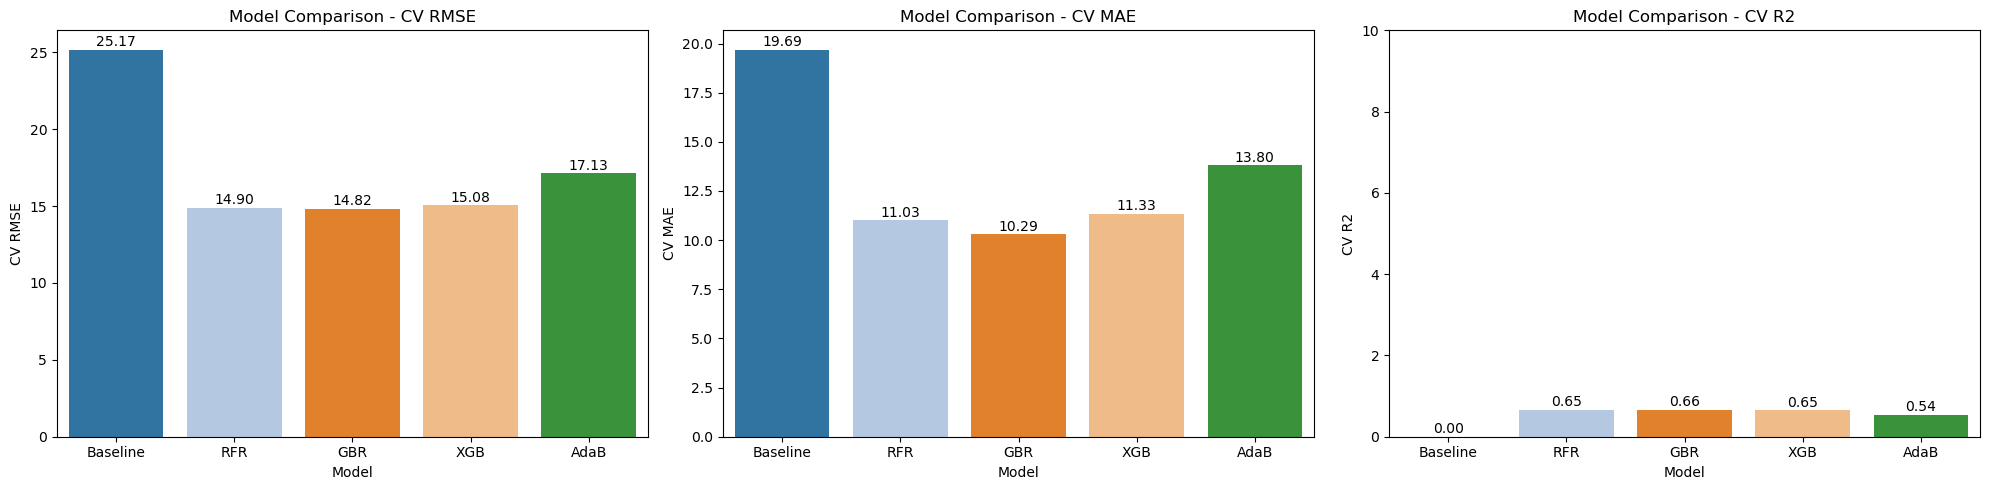

In [22]:
# Set figure size
plt.figure(figsize=(16, 20))

# Create a subplot for each metric
metrics = ['CV RMSE', 'CV MAE', 'CV R2']
num_met = len(metrics)

# Create a subplot for each metric
fig, axes = plt.subplots(1, num_met, figsize=(20, 5), sharey=False)

for i, met in enumerate(metrics):
    # Create the bar plot
    barplot = sns.barplot(x='Model', y=met, data=metric_df, ax=axes[i], hue=metric_df.index, palette='tab20', legend = False)
    axes[i].set_title(f'Model Comparison - {met}')
    axes[i].set_ylabel(met)
    axes[i].set_xlabel('Model')
    # Annotate each bar with its value
    for p in barplot.patches:
        height = p.get_height()
        axes[i].text(
            p.get_x() + p.get_width() / 2,  # x-coordinate of the annotation
            height + 0.02,                 # y-coordinate of the annotation (slightly above the bar)
            f'{height:.2f}',               # format to 2 decimal places
            ha='center',                   # horizontal alignment
            va='bottom',                   # vertical alignment
            fontsize=10,                   # font size of annotation
            color='black'                  # color of the annotation
        )

# Adjust layout
plt.ylim(0, 10)
plt.tight_layout()
plt.show()

## Step 5. Model Interpretation and Explainability

### Step 5b. Model Test Results

#### Analyze top two models (GBR & RFR) for result quality

In [23]:
# Access scores
print("RMSE Scores for each fold:", gb_rmse_scores)
print("MAE Scores for each fold:", gb_mae_scores)
print("R2 Scores for each fold:", gb_r2_scores)

RMSE Scores for each fold: [14.63784145670673, 15.822190964196025, 13.72804276402594, 15.116344162270153, 14.810417887931402]
MAE Scores for each fold: [10.011421743057557, 10.906304706911408, 9.503472788208406, 10.98379996513466, 10.033860220199585]
R2 Scores for each fold: [0.6477476706052506, 0.6350832938874131, 0.7034314292873578, 0.639952138801869, 0.6602587363120866]


In [24]:
# Calculate residuals
gb_residuals = gb_best_Y_test['Mean streambed embeddedness (%)'] - gb_best_preds

#### Predictions vs. True

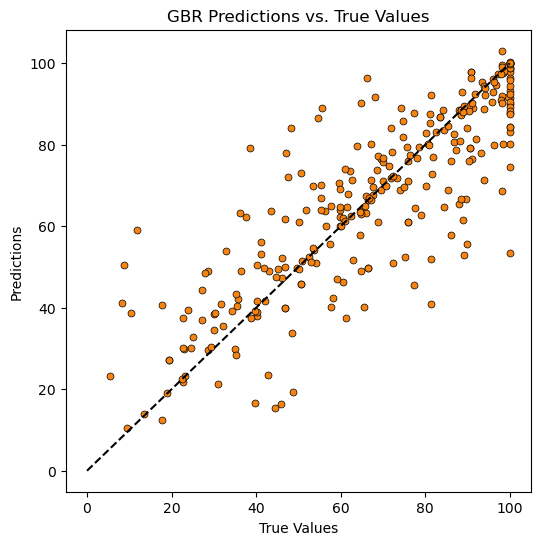

In [25]:
# Scatter plot of predictions vs. true values
plt.figure(figsize=(6, 6))
plt.scatter(gb_best_Y_test['Mean streambed embeddedness (%)'], gb_best_preds, color = '#F58413', s=25, edgecolors='black', linewidths=0.5)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('GBR Predictions vs. True Values')
plt.plot([0, 100], [0, 100], 'k--')
plt.show()

#### Residual Histogram

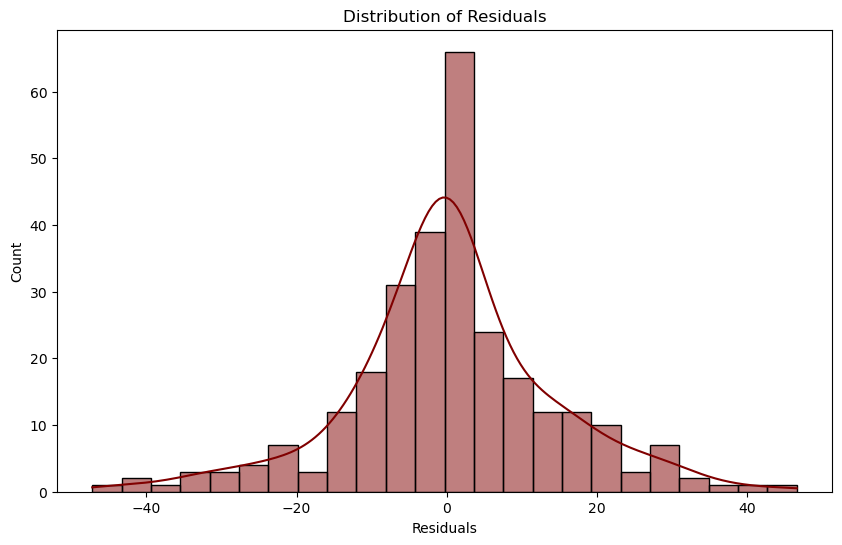

In [26]:
# Plot residuals distribution to check for Gaussian distribution
plt.figure(figsize=(10, 6))
sns.histplot(gb_residuals, kde=True, color = 'maroon')
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

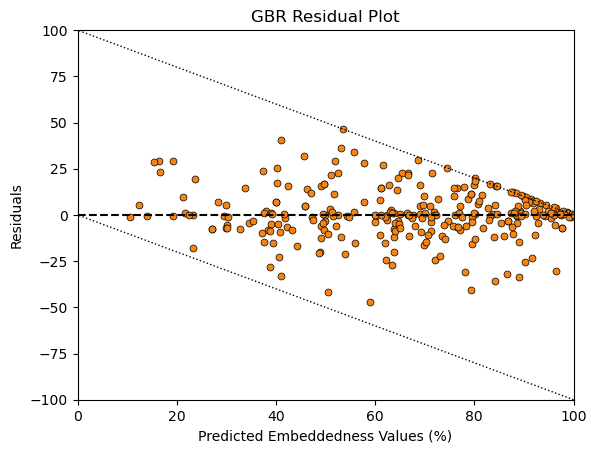

In [27]:
#Plot residuals of test results
plt.scatter(gb_best_preds, gb_residuals, color = '#F58413', s=25, edgecolors='black', linewidths=0.5)
plt.ylim(-100, 100) # Changed limit from -100% to 100% for comparison against previous models
plt.xlim(0, 100)
plt.xlabel('Predicted Embeddedness Values (%)')
plt.ylabel('Residuals')
plt.title('GBR Residual Plot')
plt.axhline(y = 0, color = 'black',linestyle = '--')
plt.plot([100, 0], [0, 100], color='black', linestyle=':', linewidth=1) # Envelope
plt.plot([100, 0], [-100, 0], color='black', linestyle=':', linewidth=1) # Envelope
plt.show()

In [28]:
# Print residual statistics
print("The maximum residual is", np.abs(gb_residuals).max(), "%.")
print("The median residual is", np.abs(gb_residuals).median(), "%.")
print("The minimum residual is", np.abs(gb_residuals).min(), "%.")

The maximum residual is 47.17488049109471 %.
The median residual is 6.598110552266039 %.
The minimum residual is 0.00037277014144621035 %.


In [29]:
# Calculate residuals
rf_residuals = rf_best_Y_test['Mean streambed embeddedness (%)'] - rf_best_preds

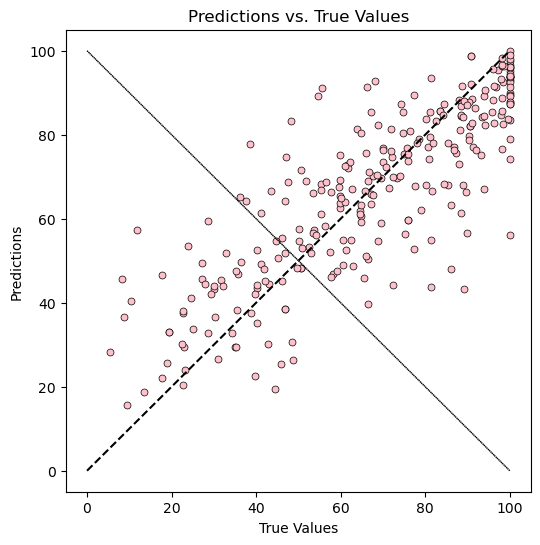

In [30]:
# Scatter plot of predictions vs. true values
plt.figure(figsize=(6, 6))
plt.scatter(rf_best_Y_test['Mean streambed embeddedness (%)'], rf_best_preds, color = 'pink', s=25, edgecolors='black', linewidths=0.5)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs. True Values')
plt.plot([0, 100], [0, 100], 'k--')
plt.plot([100, 0], [0, 100], color='black', linestyle=':', linewidth=1) # Envelope
plt.plot([0, 100], [100, 0], color='black', linestyle=':', linewidth=1) # Envelope
plt.show()

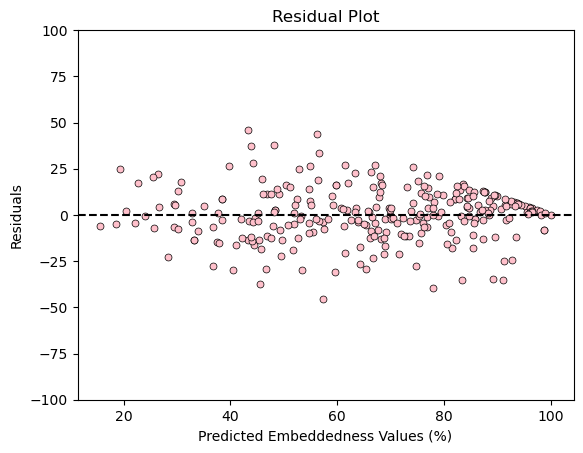

In [31]:
#Plot residuals of test results
plt.scatter(rf_best_preds, rf_residuals, color = 'pink', s=25, edgecolors='black', linewidths=0.5)
plt.ylim(-100, 100) # Changed limit from -100% to 100% for comparison against previous models
plt.xlabel('Predicted Embeddedness Values (%)')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y = 0, color = 'black',linestyle = '--')
plt.show()

In [32]:
# Print residual statistics
print("The maximum residual is", np.abs(rf_residuals).max(), "%.")
print("The median residual is", np.abs(rf_residuals).median(), "%.")
print("The minimum residual is", np.abs(rf_residuals).min(), "%.")

The maximum residual is 45.821448559500034 %.
The median residual is 8.427804328529916 %.
The minimum residual is 0.0 %.


## **Move forward with GBR Model**

#### Predictions with Errors Bars

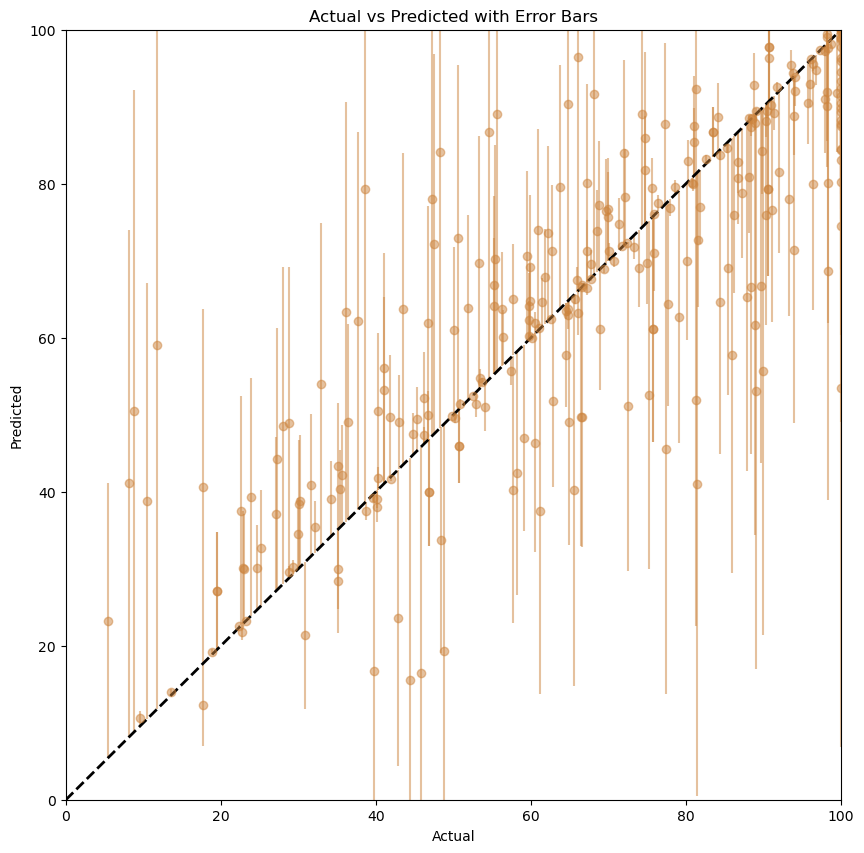

In [33]:
#Plot predictions vs actual with error bars
plt.figure(figsize=(10, 10))
plt.errorbar(gb_best_Y_test['Mean streambed embeddedness (%)'], 
             gb_best_preds, 
             yerr=np.abs(gb_best_Y_test['Mean streambed embeddedness (%)'] - gb_best_preds), 
             fmt='o', 
             alpha=0.5, 
             color = 'peru')
plt.ylim(0,100)
plt.xlim(0,100)
plt.plot([0, 100], [0, 100], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted with Error Bars')
plt.show()

#### Cumulative Accuracy Profile

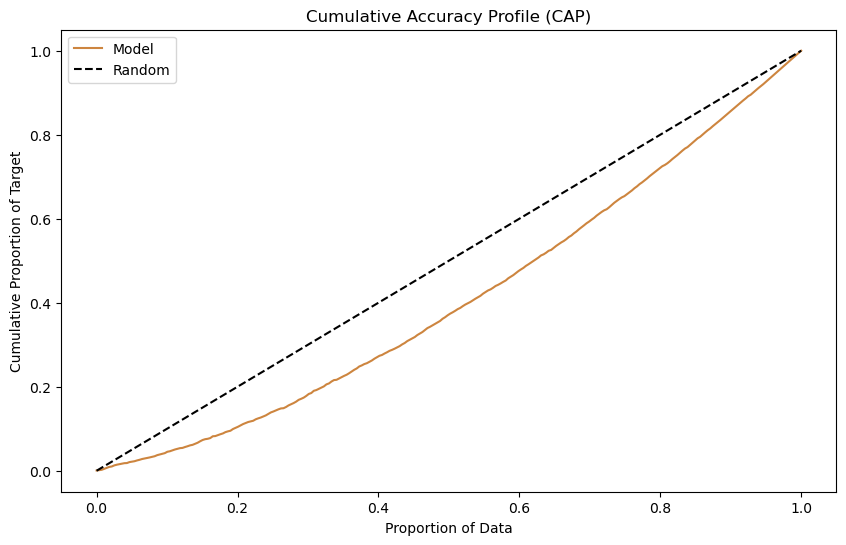

In [34]:
#Sort the predictions
sorted_indices = np.argsort(gb_best_preds)
y_sorted = gb_best_Y_test.iloc[sorted_indices].values

#Calculate the cumulative sum of actual values
cumulative_y = np.cumsum(y_sorted)

#Normalize the cumulative sum
cumulative_y = cumulative_y / cumulative_y[-1]

#Create the CAP curve
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, 1, len(cumulative_y)), cumulative_y, label='Model', color = 'peru')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('Proportion of Data')
plt.ylabel('Cumulative Proportion of Target')
plt.title('Cumulative Accuracy Profile (CAP)')
plt.legend()
plt.show()

#### Learning Curves

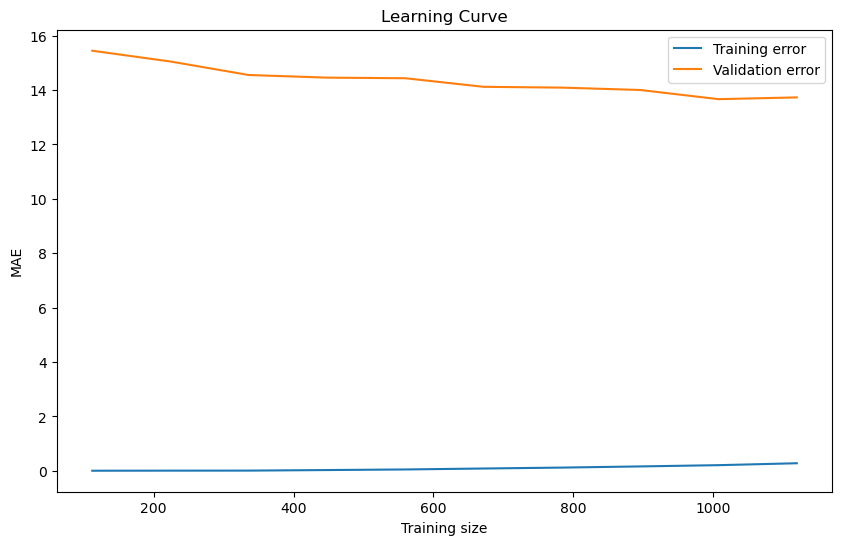

In [35]:
from sklearn.model_selection import learning_curve

#Plot learning curves for various training sizes
train_sizes, train_scores, test_scores = learning_curve(gb_model, 
                                                        x_scld, 
                                                        y, 
                                                        cv=5, 
                                                        n_jobs=-1, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), 
                                                        scoring='neg_mean_absolute_error')

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, test_scores_mean, label='Validation error')
plt.xlabel('Training size')
plt.ylabel('MAE')
plt.title('Learning Curve')
plt.legend()
plt.show()

#### Shap Plots

In [36]:
import shap

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(gb_model)
shap_values = explainer.shap_values(gb_best_X_test)

# Wrap feature names to a maximum width
import textwrap
x_test_shap = gb_best_X_test
x_test_feat = gb_best_X_test
x_test_shap.columns = [textwrap.fill(name, width=50) for name in x_test_shap.columns]
x_test_feat.columns = [textwrap.fill(name, width = 50) for name in x_test_feat.columns]

### Step 5a. Feature Importance

In [ ]:
# Define the importance types
importance_types = ['weight', 'gain', 'cover']

# Initialize a dictionary to hold importances
importances = {}

# Extract importances for each type
for importance_type in importance_types:
    importances[importance_type] = gb_model.get_booster().get_score(importance_type=importance_type)
importance_df = pd.DataFrame(importances)

<Figure size 600x1200 with 0 Axes>

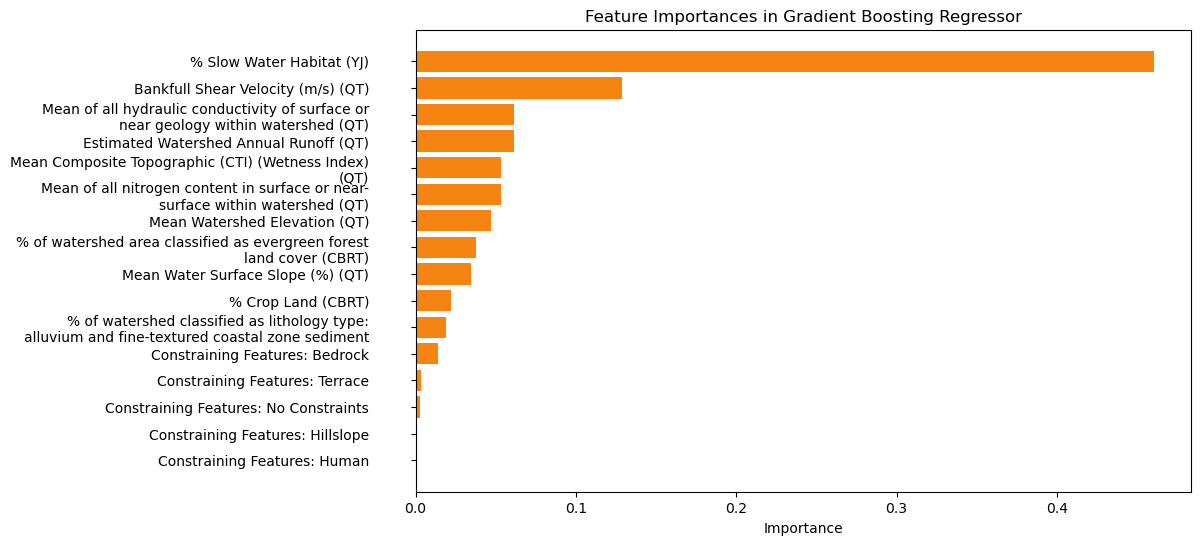

In [37]:
# Plot different importance features
num_importance_types = importance_df.columns.size
plt.figure(figsize = (10, 6 * num_importance_types))

for i, importance_type in enumerate(importance_df.columns):
    plt.subplot(num_importance_types, 1, i + 1)
    # Sort the features by importance
    sorted_features = importance_df[importance_type].sort_values(ascending = False).head(20)
    sns.barplot(x=sorted_features.values, y = sorted_features.index, palette='gist_heat', hue = sorted_features.index)
    plt.xlabel(f'Feature {importance_type.capitalize()} Importance')
    plt.ylabel('Features')
    plt.title(f'Feature Importance by {importance_type.capitalize()}')

# Save to results folder
#feat_imp_path = os.path.join(BASE_DIR, "models", "model1_streamstats_va", "results", "figures", "xgb_feature_importances.png")
#plt.savefig(feat_imp_path, dpi = 300, bbox_inches = 'tight')

# Plot bar plots
plt.tight_layout()
plt.show()

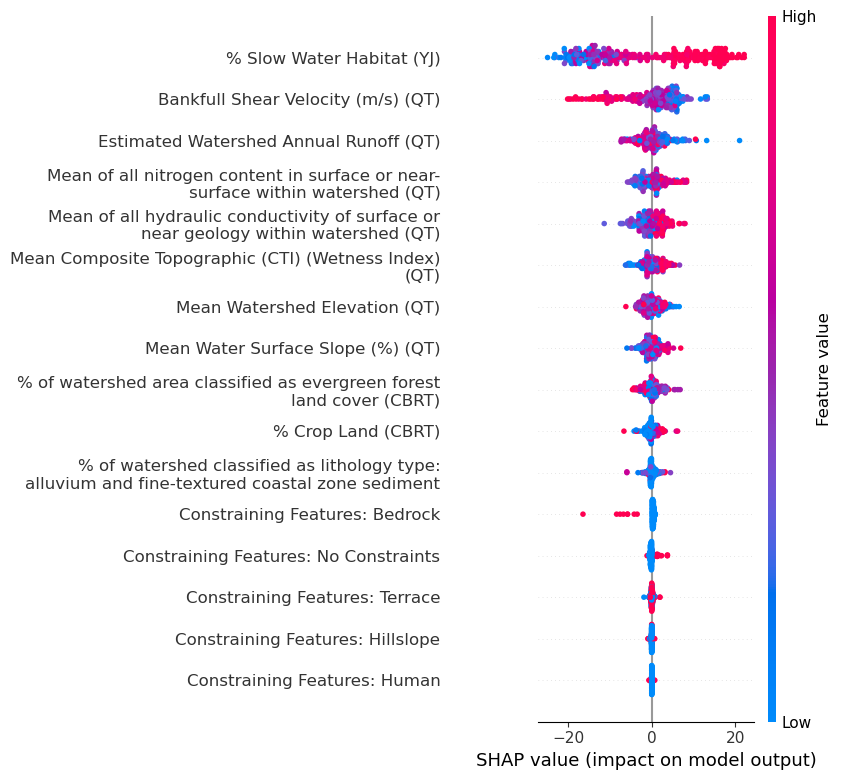

In [38]:
# Summary plot to show feature importance and effects
plt.figure(figsize=(6, 6))
shap.summary_plot(shap_values, x_test_shap, show = False)

# Customize and save
plt.gca().tick_params(axis='y', labelsize=12, pad=50)  # Increase 'pad' to add space
plt.savefig('shap_summary_plot.png', bbox_inches='tight')  # Save the plot

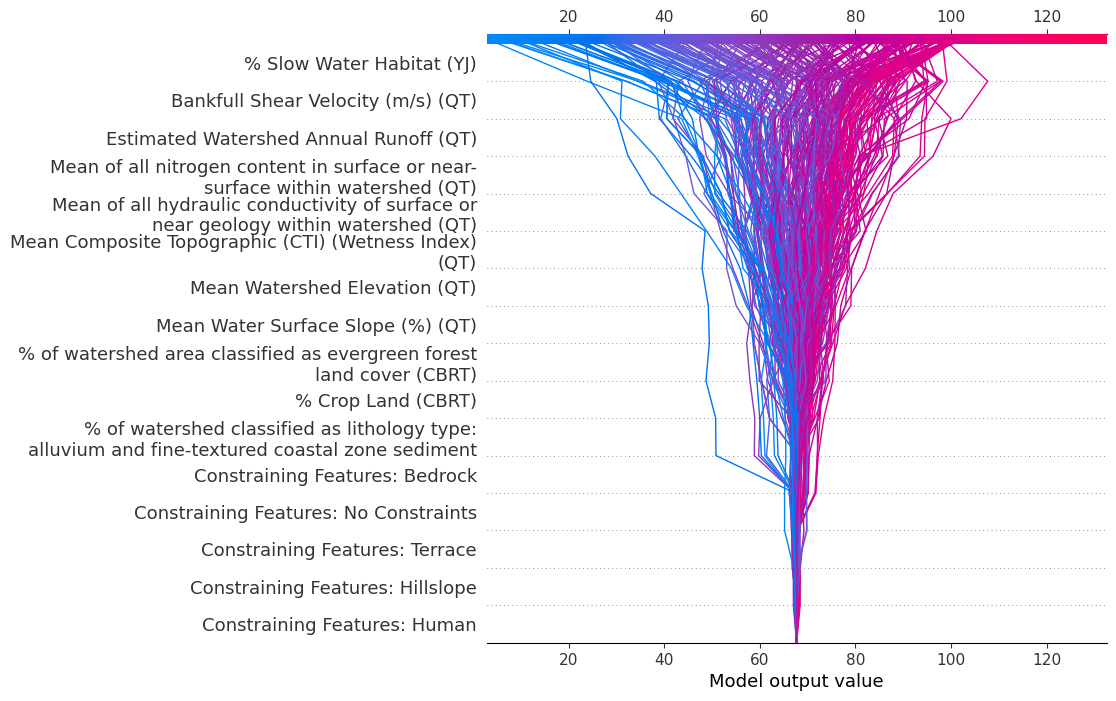

In [39]:
shap.decision_plot(explainer.expected_value, shap_values, x_test_shap)

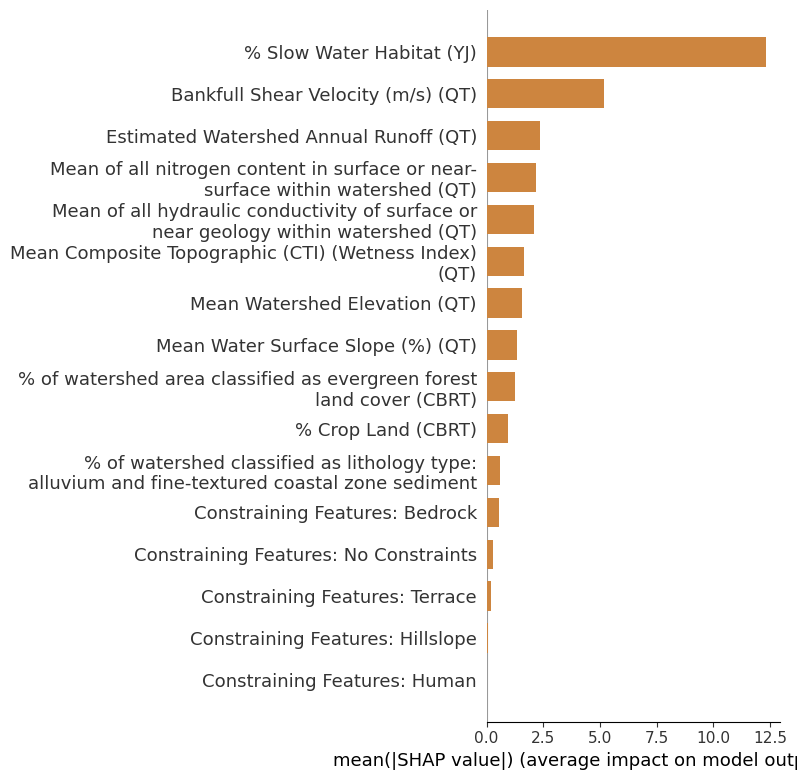

In [40]:
# Simple ranking of feature importance
shap.summary_plot(shap_values, x_test_shap, plot_type = "bar", color = 'peru')

### Step 5c. Geographic Results

In [41]:
import plotly.graph_objects as go

In [42]:
# Create dataframe for map plotting from test set
map_testset_df = pd.DataFrame(gb_best_Y_test)
map_testset_df['Prediction'] = gb_best_preds
map_testset_df['Residual'] = gb_residuals

# Print dataframe
map_testset_df

,Mean streambed embeddedness (%),Prediction,Residual
0,100.000000,87.741460,12.258540
2,96.363636,80.013903,16.349734
6,66.545455,66.556676,-0.011221
7,100.000000,84.391858,15.608142
9,100.000000,91.420946,8.579054
...,...,...,...
1382,50.090909,60.963077,-10.872168
1385,23.909091,39.325121,-15.416030
1394,10.509091,38.796991,-28.287900
1395,66.415094,49.662314,16.752780


In [43]:
# Join original dataset with test dataset to visualize various aspects
epa_testset_map = map_testset_df.merge(epa_1819,
                                        left_index = True, right_index = True,
                                        how = 'left')
# Print number of null values to validate join
print(f'Number of null values in DataFrame: ', epa_testset_map.isna().sum())

# Additional check that join is valid
print("It is", epa_testset_map['Mean streambed embeddedness (%)_x'].equals(epa_testset_map['Mean streambed embeddedness (%)_y']), "that the join is valid.")
epa_testset_map

Number of null values in DataFrame:  Mean streambed embeddedness (%)_x                                                                 0
Prediction                                                                                        0
Residual                                                                                          0
Site ID                                                                                           0
Mean streambed embeddedness (%)_y                                                                 0
% Slow Water Habitat (YJ)                                                                         0
Bankfull Shear Velocity (m/s) (QT)                                                                0
Mean Composite Topographic (CTI) [Wetness Index] (QT)                                             0
Mean Water Surface Slope (%) (QT)                                                                 0
% of watershed area classified as evergreen forest land cover (

,Mean streambed embeddedness (%)_x,Prediction,Residual,Site ID,Mean streambed embeddedness (%)_y,% Slow Water Habitat (YJ),Bankfull Shear Velocity (m/s) (QT),Mean Composite Topographic (CTI) [Wetness Index] (QT),Mean Water Surface Slope (%) (QT),% of watershed area classified as evergreen forest land cover (CBRT),...,Mean of all hydraulic conductivity of surface or near geology within watershed (QT),% of watershed classified as lithology type:\nalluvium and fine-textured coastal zone sediment,Mean Watershed Elevation (QT),Constraining Features_BEDROCK,Constraining Features_HILLSLOPE,Constraining Features_HUMAN,Constraining Features_NOCONST,Constraining Features_TERRACE,LAT_DD83,LON_DD83
0,100.000000,87.741460,12.258540,NRS18_OK_10062,100.000000,0.970282,-0.030620,0.026516,0.579510,0.000000,...,0.465743,0.000000,0.294669,0,0,0,0,1,35.545389,-99.722705
2,96.363636,80.013903,16.349734,NRS18_OK_10025,96.363636,0.970282,0.680046,0.610414,0.036675,0.739352,...,0.192926,23.863907,-0.747971,0,1,0,0,0,33.929449,-96.070242
6,66.545455,66.556676,-0.011221,NRS18_OK_10001,66.545455,0.444291,-0.364817,0.021329,-0.079120,0.665278,...,-0.599937,16.967957,-0.422483,0,1,0,0,0,35.749309,-97.134335
7,100.000000,84.391858,15.608142,NRS18_OK_11085,100.000000,0.970282,-1.409275,1.179434,-1.295363,0.073785,...,-1.956113,7.212925,-0.304472,0,0,0,0,1,36.714416,-97.792954
9,100.000000,91.420946,8.579054,NRS18_OK_10053,100.000000,0.927524,-0.970002,1.051867,-1.117907,1.407905,...,1.247630,17.550216,0.428279,0,1,0,0,0,35.885363,-97.613483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382,50.090909,60.963077,-10.872168,NRS18_WI_10248,50.090909,-0.021118,0.351495,-0.131924,0.400635,0.000000,...,-1.114032,0.000000,-0.387593,0,0,0,0,1,42.903455,-90.942482
1385,23.909091,39.325121,-15.416030,NRS18_MD_10481,23.909091,0.572056,0.721437,-1.056751,0.570161,1.283123,...,-0.798726,0.000000,-0.364034,1,0,0,0,0,39.656817,-78.409772
1394,10.509091,38.796991,-28.287900,NRS18_PA_10013,10.509091,-0.348721,-0.214064,-0.643628,-0.533295,1.174408,...,-0.425004,1.078278,0.119480,0,0,1,0,0,41.288706,-77.341228
1395,66.415094,49.662314,16.752780,NRS18_NV_10025,66.415094,-1.089092,1.655828,1.518255,1.154760,3.617756,...,0.743137,4.458628,1.088764,0,1,0,0,0,39.491596,-119.993691


In [44]:
#Create text column for map label
epa_testset_map['text'] = 'Site ID ' + epa_testset_map['Site ID'] + ', ' + 'Actual: ' + epa_testset_map['Mean streambed embeddedness (%)_x'].astype(int).astype(str) + '%' + ', ' + 'Prediction: ' + epa_testset_map['Prediction'].astype(int).astype(str) + '%'

**Export for ArcGIS Online Map:** https://arcg.is/yvzGK0

In [45]:
epa_testset_map[['Mean streambed embeddedness (%)_x',
                 'Prediction',
                 'Residual',
                 'Site ID',
                'LAT_DD83',
                 'LON_DD83']].rename(columns = {'Mean streambed embeddedness (%)_x':'Mean streambed embeddedness(%)'}).to_csv('epa_testset_map.csv')